In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("data")

In [3]:
from helpers import *

In [4]:
import time
import numpy as np
import jax.numpy as jnp

from jax import config
config.update("jax_enable_x64", True)

def process_imu_data(
    imu_data_raw,
    vref,
    acc_sens,
    gyro_sens,
    static_period,
    adc_max
):
    """
    Process raw IMU data to get acceleration
    and angular velocity in physical units

    Args:
        imu_data_raw: raw IMU data, shape (N, 7), last column is
                      timestamp, otherwise:
                      imu_data_raw[:, :3]  -> acc
                      imu_data_raw[:, 3:6] -> gyro

        vref: reference voltage of the IMU
        acc_sens: sensitivity of the accelerometer
        gyro_sens: sensitivity of the gyroscope
        static_period: period of time to compute the bias
        adc_max: maximum value of the ADC
        g: gravitational acceleration

    Returns:
        acc_data: acceleration in physical units
        gyro_data: angular velocity in physical units
        timestamp: timestamp of the data
    """
    # --------------------------------------------------------------
    # convert constants to appropiate units
    # --------------------------------------------------------------
    vref = vref*1000
    gyro_sens = gyro_sens*(180./np.pi)

    # --------------------------------------------------------------
    # compute bias
    # --------------------------------------------------------------
    # extract the static portion of the data
    static_data = imu_data_raw[
        imu_data_raw[:, -1] <= (imu_data_raw[0, -1] + static_period)
    ]

    # compute the mean of the static portion
    bias = np.mean(static_data[:, :-1], axis=0) # shape (6,)

    # --------------------------------------------------------------
    # compute the physical values
    # --------------------------------------------------------------
    # Compute scale factors
    acc_sf = (vref/adc_max)/acc_sens
    gyro_sf = (vref/adc_max)/gyro_sens

    # Bias correction and conversion for acc. data
    acc_data = (imu_data_raw[:, :3] - bias[:3])*acc_sf
    # Axis correction (due to device design)
    acc_data[:, 0] = -acc_data[:, 0]
    acc_data[:, 1] = -acc_data[:, 1]
    # add gravity since we expect Az to be g during static period
    acc_data[:, 2] += 1.
    
    # Bias correction and conversion for gyro. data
    gyro_data = (imu_data_raw[:, 3:6] - bias[3:])
    gyro_data[:, [0, 1, 2]] = gyro_data[:, [1, 2, 0]]*gyro_sf
    return acc_data, gyro_data, imu_data_raw[:, -1]

In [5]:
import transforms3d as tf3d

def euler(rot):
    """
    Convert rotation matrix or quaternion to euler angles.
    """
    # assert that rot is of type list
    if type(rot) == dict:
        rot = rot['rots']
        return jnp.array([tf3d.euler.mat2euler(rot[i]) for i in range(rot.shape[0])])
    return jnp.array([tf3d.euler.quat2euler(q) for q in rot], dtype=jnp.float64)

def plot_all(
    vicon_data,
    q_motion,
    a_imu,
    a_obsrv,
    acc_est_label="Obsv. model",
    orien_est_label="Motion model"
):
    ts = np.array(list(range(len(q_motion))))
    fig, axs = plt.subplots(3, 2, figsize=(30, 10))

    # Plotting the acceleration data
    axs[0, 0].plot(ts, a_obsrv[:, 0], label=acc_est_label + ' (Ax)', color='r')
    axs[0, 0].plot(ts, a_imu[:, 0],   label='IMU (Ax)',              color='b')
    axs[1, 0].plot(ts, a_obsrv[:, 1], label=acc_est_label + ' (Ay)', color='r')
    axs[1, 0].plot(ts, a_imu[:, 1],   label='IMU (Ay)',              color='b')
    axs[2, 0].plot(ts, a_obsrv[:, 2], label=acc_est_label + ' (Az)', color='r')
    axs[2, 0].plot(ts, a_imu[:, 2],   label='IMU (Az)',              color='b')

    # Calculating Euler angles
    if q_motion.shape[1] != 3:
        eulers_q_motion = np.array(euler(q_motion))
    else: eulers_q_motion = q_motion
    eulers_vicon = np.array(euler(vicon_data))

    # Since we estimated from 1:T, we need to slice q_motion and vicon_data
    # to match the size of q_optim
    q_motion = q_motion[1:]
    eulers_vicon = eulers_vicon[1:]

    # Plotting the Euler angles
    axs[0, 1].plot(eulers_q_motion[:, 0], label=orien_est_label + ' (Roll)', color='r')
    axs[0, 1].plot(eulers_vicon[:, 0],    label='Vicon (Roll)',              color='b')
    axs[1, 1].plot(eulers_q_motion[:, 1], label=orien_est_label + ' (Pitch)',color='r')
    axs[1, 1].plot(eulers_vicon[:, 1],    label='Vicon (Pitch)',             color='b')
    axs[2, 1].plot(eulers_q_motion[:, 2], label=orien_est_label + ' (Yaw)',  color='r')
    axs[2, 1].plot(eulers_vicon[:, 2],    label='Vicon (Yaw)',               color='b')

    # Setting titles for each subplot
    axs[0, 0].set_title('Ax')
    axs[1, 0].set_title('Ay')
    axs[2, 0].set_title('Az')
    axs[0, 1].set_title('Roll')
    axs[1, 1].set_title('Pitch')
    axs[2, 1].set_title('Yaw')

    # Adding legends to each subplot
    axs[0, 0].legend()
    axs[1, 0].legend()
    axs[2, 0].legend()
    axs[0, 1].legend()
    axs[1, 1].legend()
    axs[2, 1].legend()

    plt.show()

In [6]:
from jax_quaternion import *
import transforms3d.quaternions as tq

def motion_model(q, w_ts, t_ts):
    """
    Implements quaternion kinematics motion model
    given angular velocities w_ts and the differences between
    consecutive time stamps tau_ts from calibrated imu data.
    """
    tau_ts = (t_ts[1:] - t_ts[:-1]).reshape(-1, 1)
    exp_term = qexp_jax(jnp.hstack((jnp.zeros((w_ts.shape[0]-1, 1)), w_ts[:-1] * tau_ts / 2)))
    for i in range(w_ts.shape[0]-1):
        q = q.at[i+1].set(tq.qmult(q[i], exp_term[i]))
    return q, exp_term

def observation_model(qs):
    """
    Observation model for quaternion-based motion.

    Parameters:
    qs (array): Quaternion array.

    Returns:
    array: Observed acceleration.
    """
    g_unit = jnp.array([0., 0., 0., 1.]).reshape(1, 4)
    result = qmult_jax(qinverse_jax(qs), qmult_jax(g_unit, qs))

    return result[:, 1:]

def sensor_fusion(gyro_data, accel_data, delta_t, alpha=0.5):
    """
    Implements drift correction via complementary filtering on gyroscopic and accelerometer data for
    roll, pitch, and yaw angles.

    Parameters:
    gyro_data (array): Gyroscopic data with shape (N, 3).
    accel_data (array): Accelerometer data with shape (N, 3).
    delta_t (array): Time deltas with shape (N-1,).

    Returns:
    array: Fused sensor data for roll, pitch, and yaw angles.
    """
    N = gyro_data.shape[0]
    angles = jnp.zeros((N, 3))  # Initialize roll, pitch, yaw angles array

    # Calculate initial roll and pitch from the accelerometer data
    roll = jnp.arctan2(accel_data[0, 1], accel_data[0, 2])
    pitch = jnp.arctan2(-accel_data[0, 0], jnp.sqrt(accel_data[0, 1]**2 + accel_data[0, 2]**2))
    yaw = 0.0  # Initialize yaw to 0 as we cannot estimate it from accelerometer
    
    angles = angles.at[0].set(jnp.array([roll, pitch, yaw]))

    for i in range(1, N):
        # Gyro integration for each axis
        gyro_angles = angles[i-1] + gyro_data[i-1] * delta_t[i-1]
        
        # Accelerometer angle calculations
        roll = jnp.arctan2(accel_data[i, 1], accel_data[i, 2])
        pitch = jnp.arctan2(-accel_data[i, 0], jnp.sqrt(accel_data[i, 1]**2 + accel_data[i, 2]**2))
        # Yaw remains integrated gyro value as there's no accelerometer data for it

        # Apply complementary filter for roll and pitch, and gyro integration for yaw
        fused_roll = alpha * gyro_angles[0] + (1 - alpha) * roll
        fused_pitch = alpha * gyro_angles[1] + (1 - alpha) * pitch
        fused_yaw = gyro_angles[2]  # Assuming we have no other sensor data for yaw

        angles = angles.at[i].set(jnp.array([fused_roll, fused_pitch, fused_yaw]))
    
    return angles

In [7]:
path_to_dataset = "../data/"
raw_imu_data = read_imu_data(9, path_to_dataset)
vicon_data = read_vicon_data(9, path_to_dataset)

[[511. 488. 606.]
 [511. 489. 605.]
 [510. 489. 605.]
 [510. 489. 605.]
 [510. 488. 606.]
 [509. 488. 606.]
 [509. 488. 607.]
 [509. 488. 607.]
 [509. 488. 608.]
 [510. 490. 608.]
 [511. 491. 608.]
 [511. 491. 607.]
 [511. 491. 607.]
 [511. 491. 607.]
 [511. 491. 607.]
 [511. 490. 607.]
 [512. 491. 607.]
 [512. 492. 606.]
 [511. 493. 606.]
 [510. 494. 606.]
 [510. 495. 606.]
 [510. 496. 606.]
 [510. 496. 605.]
 [509. 496. 604.]
 [509. 497. 604.]
 [509. 499. 606.]
 [509. 500. 606.]
 [510. 501. 606.]
 [511. 501. 606.]
 [511. 502. 605.]
 [510. 503. 607.]
 [510. 504. 606.]
 [511. 505. 606.]
 [513. 505. 607.]
 [514. 504. 606.]
 [513. 503. 605.]
 [511. 502. 604.]
 [508. 501. 603.]
 [506. 500. 603.]
 [504. 499. 603.]
 [504. 500. 603.]
 [504. 502. 604.]
 [504. 503. 605.]
 [505. 504. 605.]
 [506. 504. 606.]
 [508. 504. 606.]
 [509. 503. 606.]
 [509. 503. 607.]
 [507. 502. 607.]
 [505. 502. 609.]
 [505. 501. 610.]]


In [8]:
vref = 3.3
acc_sens = 330
gyro_sens = 3.33
static_period = 5.0
adc_max = 1023

In [9]:
processed_imu_data = process_imu_data(
    raw_imu_data,
    vref = vref,
    acc_sens = acc_sens,
    gyro_sens = gyro_sens,
    static_period = static_period,
    adc_max = adc_max
)

In [10]:
a_ts, w_ts, t_ts = processed_imu_data

In [11]:
a_ts

array([[ 5.86510264e-05, -1.75953079e-04,  9.99413490e-01],
       [ 5.86510264e-05, -1.75953079e-04,  9.99413490e-01],
       [ 5.86510264e-05, -1.75953079e-04,  9.99413490e-01],
       ...,
       [ 5.86510264e-05, -1.75953079e-04,  9.99413490e-01],
       [ 5.86510264e-05, -1.75953079e-04,  9.99413490e-01],
       [ 5.86510264e-05, -1.75953079e-04,  9.99413490e-01]])

In [12]:
# w_ts = jnp.load("../imu_vals.npy")[:, 3:]

In [13]:
q_motion = jnp.zeros((w_ts.shape[0], 4), dtype=jnp.float64)
q_motion = q_motion.at[0, 0].set(1.)
q_motion, exp_term = motion_model(q_motion, w_ts, t_ts)
a_obsrv = observation_model(q_motion)

CUDA backend failed to initialize: Found cuSOLVER version 11401, but JAX was built against version 11502, which is newer. The copy of cuSOLVER that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [14]:
def theta_to_quat(theta):
    quat = jnp.array([tf3d.euler.euler2quat(*row) for row in theta])
    return quat

theta_fusion = sensor_fusion(w_ts, a_ts, (t_ts[1:] - t_ts[:-1]).reshape(-1, ), alpha=0.5)
a_theta_fusion = observation_model(theta_to_quat(theta_fusion))

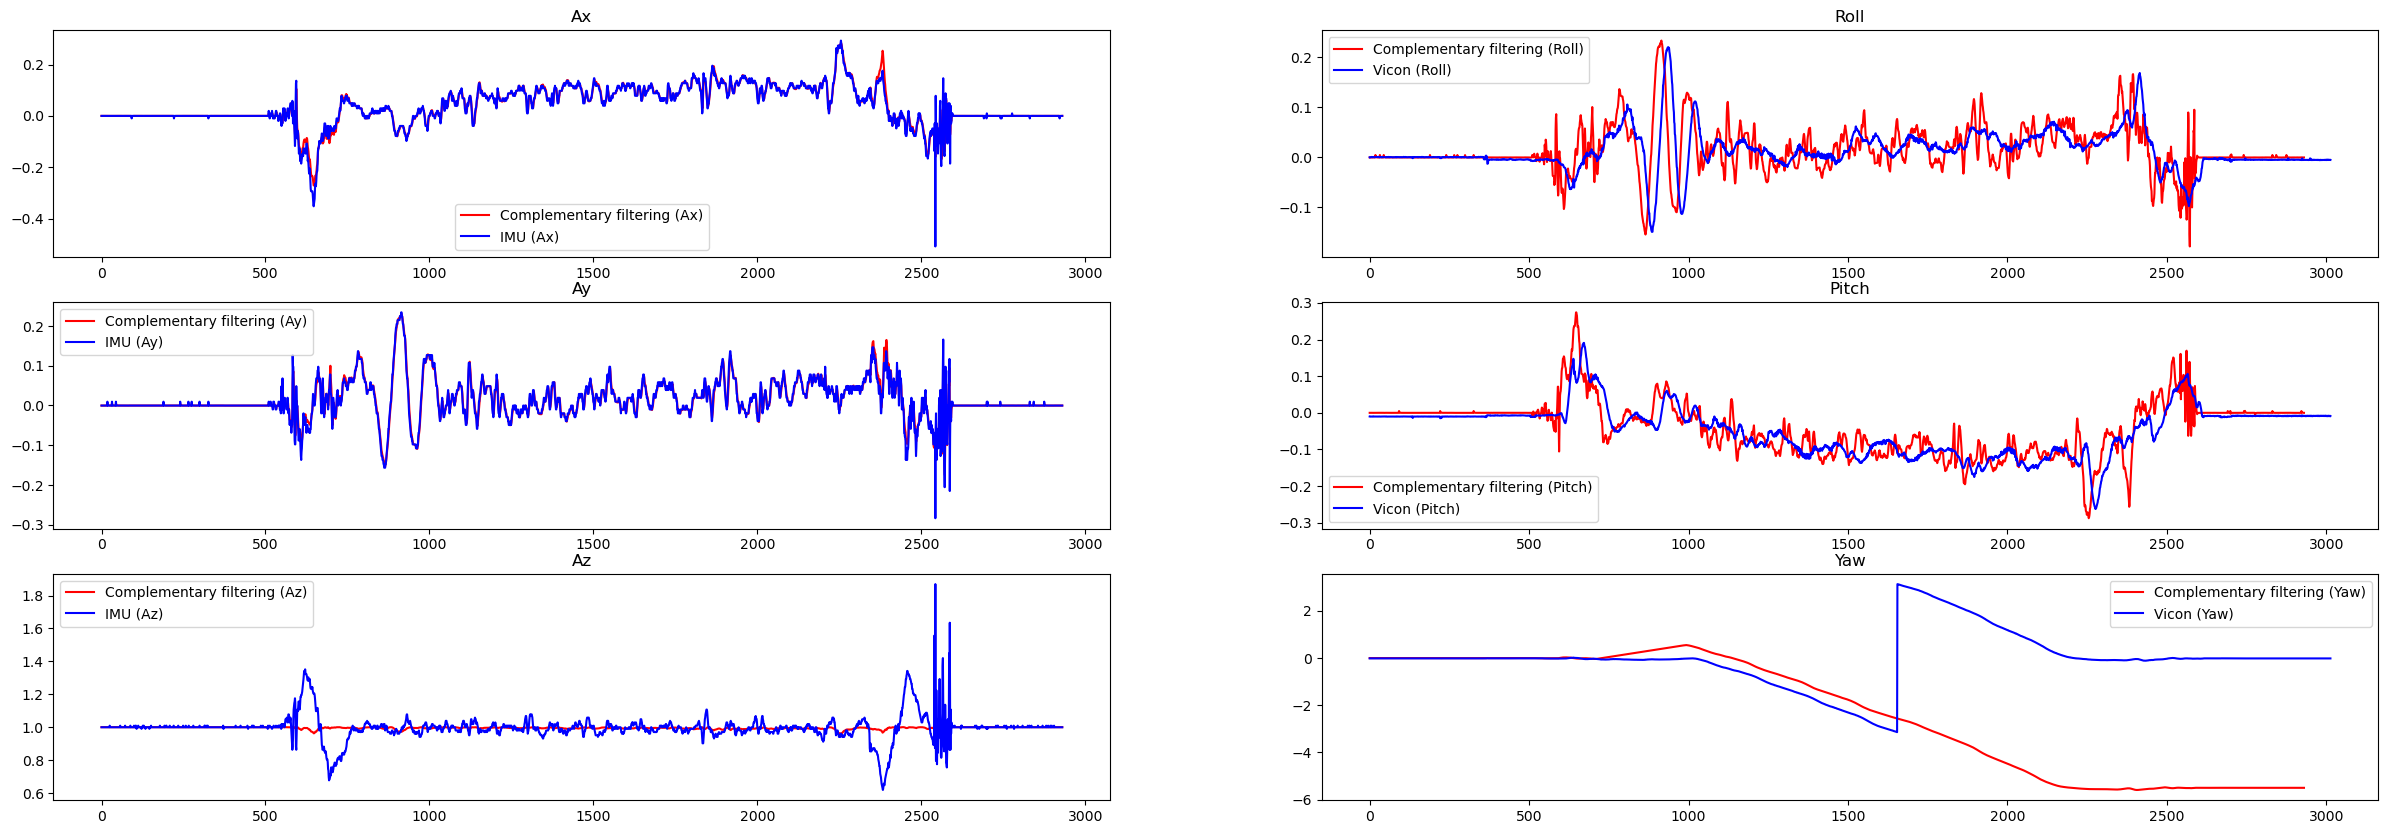

In [15]:
plot_all(vicon_data, theta_fusion, a_ts, a_theta_fusion, acc_est_label="Complementary filtering", orien_est_label="Complementary filtering")

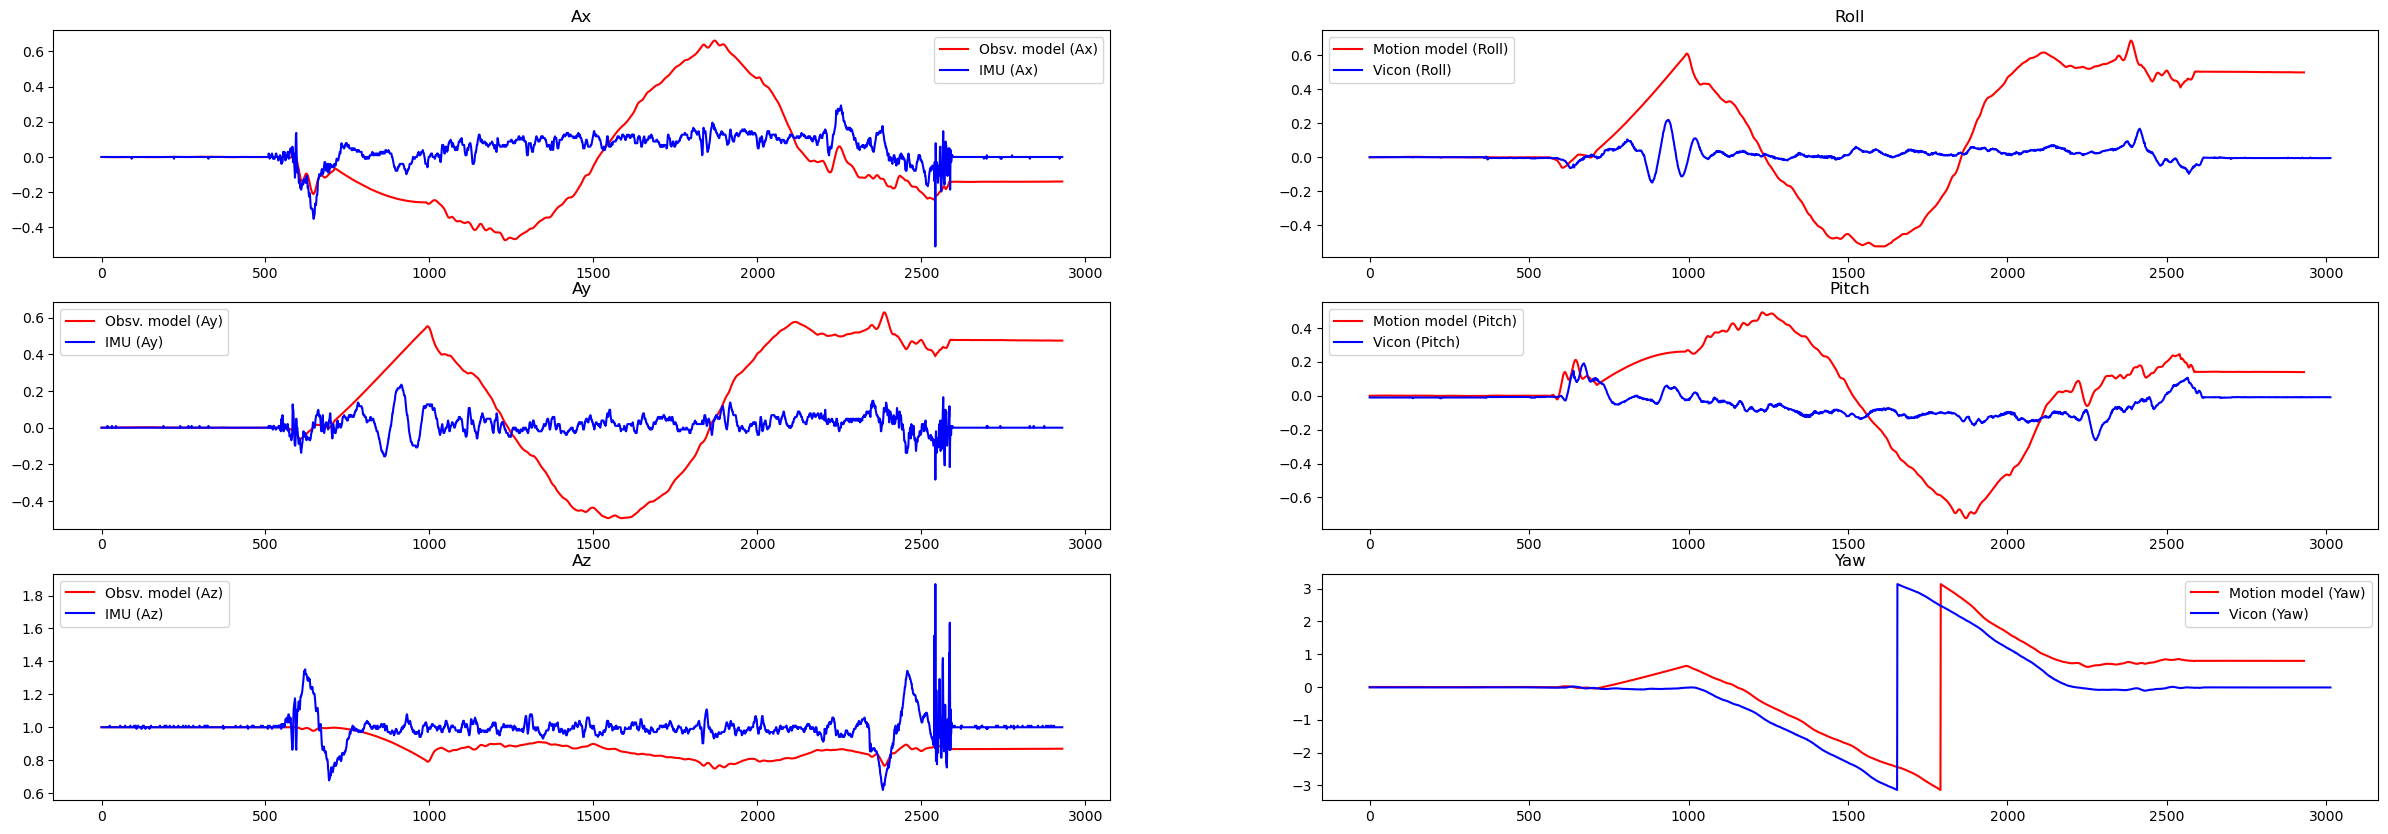

In [16]:
plot_all(vicon_data, q_motion, a_ts, a_obsrv)